#### Imports, check that GPU is used

In [11]:
! nvcc  --version
! pip install tensorflow keras --quiet
! pip install seaborn --quiet
! pip install kaggle --quiet

# needed for AugMix (removed)
# !pip install keras-cv --quiet

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


In [12]:
# dataset
import shutil
import os

import pandas as pd
import collections

# model
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import optimizers

import keras_tuner as kt
# from keras_cv.layers import AugMix

# graphs/stats
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
#assert 'GPU' in str(device_lib.list_local_devices())
#assert len(tf.config.list_physical_devices('GPU')) > 0

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Dataset preparation

The dataset contains 2 folders
*   Infected
*   Parasitized
And a total of 27,558 images.
Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/
And uploaded here, so anybody trying to start working with this dataset can get started immediately, as to download the
dataset from NIH website is quite slow.

1. kaggle automatic download
2. load and split the dataset in train/val (80/20) & getting label names
3. compute dataset statistics
4. dataset standardization
5. dataset augmentation

#### Download **Kaggle** *malaria NIH dataset*
You are required to load your personal Kaggle API keys (kaggle.json) into colab, then the NIH dataset will be downloaded directly from Kaggle

In [14]:
# make a kaggle directory, copy the loaded kaggle API key
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
# change r/w permissions
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/teamspace/studios/this_studio/.kaggle’: File exists


In [15]:
# remove the dataset folder if it exists
! rm -r cell_images

# download the NIH malaria dataset directly from kaggle
! kaggle datasets download iarunava/cell-images-for-detecting-malaria
# optionally rename, unzip the downloaded dataset
# ! mv cell-images-for-detecting-malaria.zip dataset.zip
! unzip -qq cell-images-for-detecting-malaria.zip
! rm cell-images-for-detecting-malaria.zip

# the dataset contains a duplicated folder, to remove it:
try:
  shutil.rmtree('./cell_images/cell_images')
except:
    pass

rm: cannot remove 'cell_images': No such file or directory


Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


#### Loading, splitting, standardizing the dataset and getting class names

In [16]:
# dataset folder
directory = "./cell_images"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)

# Concatenate data paths with labels
file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, Label_path_series], axis=1)

In [17]:
# splitting the dataset and getting class names
img_height = 128
img_width = 128
batch_size = 32
SEED = 123 # for reproducibility

# training, test set split
# resizing already handled by TensorFlow
# no need to reshape

print('Loading and splitting the tf_dataset')
train_set, test_set = keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,  # 80/20%
  subset="both",
  # shuffle=False,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary'    # parasitized/uninfected
)

Loading and splitting the tf_dataset


Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Using 5511 files for validation.


In [18]:
# getting the class names
classes = train_set.class_names
num_classes = len(classes)
print(f'[0={classes[0]}, 1={classes[1]}]')

[0=Parasitized, 1=Uninfected]


The images need to be standardized, so we use a lambda function to standardize them so that they have values in (0,1)

In [19]:
# train_set = train_set.map(lambda x, y: (x/255, y))
test_set = test_set.map(lambda x, y: (x/255, y))

for image, _ in train_set.take(5):
    img = image.numpy()
    print("Image shape:", img.shape)
    print("Pixel value range: min =", img.min(), ", max =", img.max())

Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 235.98145
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 238.88544
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 233.0232
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 238.07
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 237.45357


2025-05-13 20:24:50.804515: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Compute some dataset statistics

In [20]:

# calculates how many images there are for each class
def num_img_per_class(dataset):
  class_counts = collections.Counter()
  for _, labels in dataset:
      class_indices = labels.numpy().squeeze().astype(int)  # (batch_size, 1) → (batch_size,)
      class_counts.update(map(int, class_indices))
  return class_counts

# Get counts
train_class_counts = num_img_per_class(train_set)
val_class_counts = num_img_per_class(test_set)
print('Training set:', train_class_counts)
print('Validation set:', val_class_counts)

2025-05-13 20:24:51.985143: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training set: Counter({0: 11070, 1: 10977})
Validation set: Counter({1: 2802, 0: 2709})


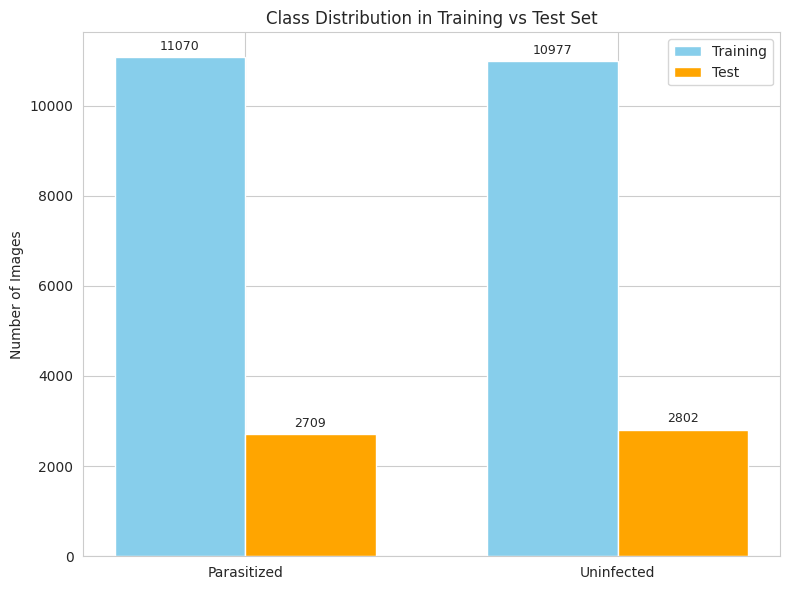

In [21]:
# bar diagram of training and validation classes distribution
labels_map = {0: 'Parasitized', 1: 'Uninfected'}

# Prepare data
x_labels = [labels_map[i] for i in sorted(labels_map.keys())]
x_pos = range(len(x_labels))
train_vals = [train_class_counts[i] for i in sorted(labels_map.keys())]
val_vals = [val_class_counts[i] for i in sorted(labels_map.keys())]

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Plot bars
bar_width = 0.35
bars1 = plt.bar([i - bar_width/2 for i in x_pos], train_vals, width=bar_width, label='Training', color='skyblue')
bars2 = plt.bar([i + bar_width/2 for i in x_pos], val_vals, width=bar_width, label='Test', color='orange')

# Add counts on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height}', ha='center', va='bottom', fontsize=9)

# Final touches
plt.xticks(ticks=x_pos, labels=x_labels)
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training vs Test Set")
plt.legend()
plt.tight_layout()
plt.show()

As you can see the class distribution is almost identical both for the training set and test set.
We will now show some images

/tmp/ipykernel_41997/1356102884.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(labels[i].numpy())], fontsize=6)
2025-05-13 20:24:52.976957: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


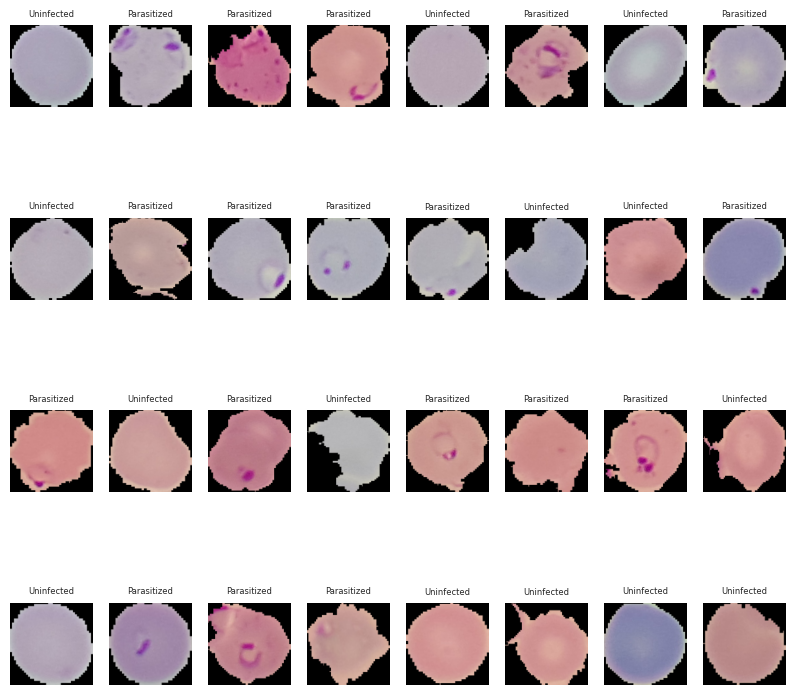

In [22]:
plt.figure(figsize=(10, 10))

for images, labels in train_set.take(1):
    num_images = batch_size  # Show more images
    for i in range(num_images):
        ax = plt.subplot(4, 8, i+1)  # 4x8 grid
        plt.imshow((images[i].numpy()).astype("uint8"))
        plt.title(classes[int(labels[i].numpy())], fontsize=6)
        plt.axis("off")

plt.subplots_adjust(hspace=0)
plt.show()

### Data augmentation (custom pipeline)

We will now extend (double) the training dataset by adding images obtained with various data augmentation techniques. The augmented dataset is merged with the training set to enalrge it. At last, the merged dataset is normalized.

In [23]:

# we have discovered that AugMix, which has great theoretical performances does not work well
# on our medical images as it introduces too many color variations, so we moved to a more
# conventional data augmentation pipeline
# AugMix(
#         severity=1,
#         chain_depth=1,
#         alpha=0.1,
#         value_range=(0, 255),
#     ),
# see https://arxiv.org/abs/1912.02781 for details on AugMix

preprocessing = keras.Sequential([
    # geometric transformations
    layers.RandomRotation(factor=0.2),
    layers.RandomFlip(mode='horizontal_and_vertical'),

    # illumination transformations
    layers.RandomBrightness(factor=0.15),
    layers.RandomContrast(factor=0.15),

    # some noise
    layers.GaussianNoise(stddev=0.05),
    #layers.Rescaling(1./255), # data standardization
])

augmented_dataset = train_set.map(lambda x, y: (preprocessing(x), y))
# concatenate the two datasets to form a big one
train_set = train_set.concatenate(augmented_dataset)

print('Augmented set size:', augmented_dataset.cardinality().numpy()*batch_size)
print('Merged set size:', train_set.cardinality().numpy()*batch_size)



Augmented set size: 22048
Merged set size: 44096


Now we standardize the training set as well as the merged dataset

In [24]:
train_set = train_set.map(lambda x, y: (x/255, y))

for image, _ in train_set.take(5):
    img = image.numpy()
    print("Image shape:", img.shape)
    print("Pixel value range: min =", img.min(), ", max =", img.max())

Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9500137
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9254174
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9361036
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9257621
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.93119043


The images are preprocessed and standardized

/tmp/ipykernel_41997/2243483184.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(labels[i].numpy())], fontsize=6)


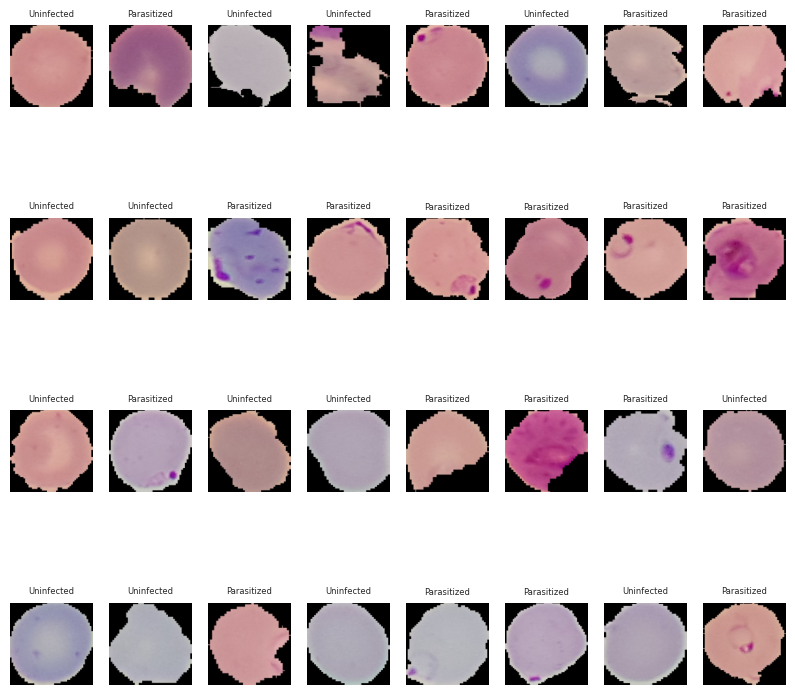

In [25]:
plt.figure(figsize=(10, 10))

for images, labels in train_set.take(1):
    num_images = batch_size  # Show more images
    for i in range(num_images):
        ax = plt.subplot(4, 8, i+1)  # 4x8 grid
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[int(labels[i].numpy())], fontsize=6)
        plt.axis("off")

plt.subplots_adjust(hspace=0)
plt.show()


As you can see the images are changed, we can finally apply some optimizations

In [26]:
# cache and prefetch for faster training
train_set = train_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
#TODO: remove it and use keras tuner (right now implement a simple CNN to use dataset)
# Define the input shape
input_shape = (128, 128, 3) # Height, Width, Channels (RGB)

# Build the Sequential model
model = keras.Sequential([
    # First Convolutional Block (Reduced filters)
    # First Convolutional Block (increased filters)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    #layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    #layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Global Average Pooling
    layers.GlobalAveragePooling2D(),

    # Dense Layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    # Output Layer
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Print the model summary to see the layers and dimensions
# model.summary()

model.fit(train_set, epochs=20)
loss, accuracy = model.evaluate(test_set, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2025-05-13 20:29:26.306873: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3551', 4 bytes spill stores, 4 bytes spill loads

2025-05-13 20:29:26.453545: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4001', 16 bytes spill stores, 16 bytes spill loads



 682/1378 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8128 - loss: 0.4176

2025-05-13 20:29:36.229848: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3551', 8 bytes spill stores, 8 bytes spill loads

2025-05-13 20:29:50.557075: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 303.26MiB (rounded to 317994496)requested by op 
2025-05-13 20:29:50.557158: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-05-13 20:29:50.557168: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 7417, Chunks in use: 7417. 1.81MiB allocated for chunks. 1.81MiB in use in bin. 37.5KiB client-requested in use in bin.
2025-05-13 20:29:50.557173: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 34, Chunks in use: 34. 17.2KiB allocated for chunks. 17.2KiB in use in bin. 17.2KiB client-

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_41997/2650904890.py", line 56, in <module>

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 317994344 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_167422]

In [30]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 827,205 (3.16 MB)

 Trainable params: 275,329 (1.05 MB)

 Non-trainable params: 1,216 (4.75 KB)

 Optimizer params: 550,660 (2.10 MB)